In [ ]:
#imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
import numpy as np
import os

In [ ]:
#Paths
dataset_dir = "/kaggle/input/chest-xray-images-guangzhou-women-and-childrens/chest_xray/"
train_dir = os.path.join(dataset_dir, "train")
test_dir  = os.path.join(dataset_dir, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
#use the saved model or train one.

#CONFIGURATION
load_path = 'ResNet_pneumonia_cnn.keras'
save_path = 'ResNet_pneumonia_cnn_v2.keras' # Writable directory
model = None

if os.path.exists(load_path):
    print(f"Found model file at {load_path}")
    try:
        model = tf.keras.models.load_model(load_path)
        print("Model loaded successfully! Skipping training.")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Proceeding to training pipeline...")
        model = None
else:
    print(f"No model found at {load_path}")
    print("Proceeding to training pipeline...")

Found model file at ResNet_pneumonia_cnn.keras
Error loading model: Layer "dense_4" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_369>, <KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_370>]
Proceeding to training pipeline...


In [ ]:
if model is None:
    
    #THE GENERATOR
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input, # <--- The ResNet Way
        validation_split=0.2,
        # Add augmentation if you want (rotation, zoom, etc.)
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )
    

    # Load data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    # THE MODEL
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze it
    base_model.trainable = False
    
    # Add the Head 
    # Note: ResNet often uses GlobalAveragePooling2D instead of Flatten, 
    # because the feature maps are deeper (2048 channels).
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(), # Better than Flatten for ResNet
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # ResNet is powerful, so we prevent overfitting
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile and Train
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 1. Get all the labels from the generator
    # train_generator.classes gives an array like [0, 0, 1, 1, 1, 0...]
    train_labels = train_generator.classes
    
    # 2. Automatically calculate the weights
    # 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    
    # 3. Convert to a dictionary (Keras requires a dictionary {0: weight, 1: weight})
    class_weights = dict(enumerate(class_weights_array))
    
    # Print to verify
    print(f"Auto-Calculated Weights: {class_weights}")

    history = model.fit(
        train_generator,
        epochs=10, # Or whatever you choose
        validation_data=val_generator,
        class_weight=class_weights  
    )

    model.save(save_path)

else:
    print("skipped training")

skipped training


In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

In [ ]:
#Final evaluation (true test set)
test_gen.reset()
pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.1).astype(int).ravel() # Lower threshold to prioritize recall (medical setting)
true_labels = test_gen.classes

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step


In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(
        true_labels,
        pred_labels,
        target_names=["Normal", "Pneumonia"]
    )
)


              precision    recall  f1-score   support

      Normal       0.90      0.85      0.88       234
   Pneumonia       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



Generating Heatmap...


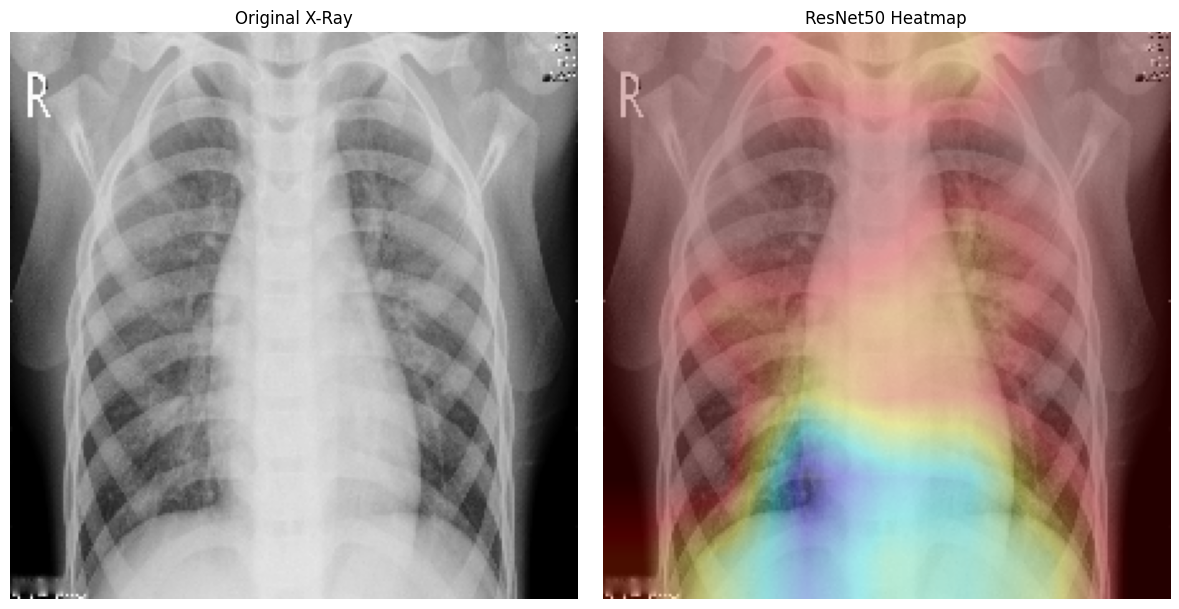

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# --- 1. THE ROBUST GRAD-CAM FUNCTION ---
def make_gradcam_heatmap_manual(img_array, model, pred_index=None):
    #model.layers[0] is the ResNet50 Base
    #model.layers[1:] are the Head (Pooling, Dense, Dropout, Dense)
    
    # Isolate the parts
    base_model = model.layers[0]
    classifier_layers = model.layers[1:]
    
    with tf.GradientTape() as tape:
        # STEP 1: Run image through the Base (ResNet)
        # We watch this output because we need its gradient
        conv_outputs = base_model(img_array)
        tape.watch(conv_outputs)
        
        # STEP 2: Run that output through the rest of the layers manually
        preds = conv_outputs
        for layer in classifier_layers:
            preds = layer(preds)
            
        # Get the top predicted class
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # STEP 3: Gradient Calculation
    # We want the gradient of the "Prediction" with respect to the "ResNet Output"
    grads = tape.gradient(class_channel, conv_outputs)

    # STEP 4: Global Average Pooling of Gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # STEP 5: Weighting the Feature Map
    # Multiply the feature map (conv_outputs) by the "importance" (pooled_grads)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 2. RUN IT ---
# Pick a test image (Pneumonia)
img_dir = '/kaggle/input/chest-xray-images-guangzhou-women-and-childrens/chest_xray/test/PNEUMONIA'
img_name = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, img_name)

# Preprocess (ResNet Style)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Generate
print("Generating Heatmap...")
heatmap = make_gradcam_heatmap_manual(img_array, model)

# --- 3. VISUALIZE ---
img_original = cv2.imread(img_path)
img_original = cv2.resize(img_original, (224, 224))

# Colorize
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_resized = np.uint8(255 * heatmap_resized)
jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose
superimposed_img = jet_heatmap * 0.4 + img_original
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title("Original X-Ray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("ResNet50 Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()